In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Generation

In [2]:
customers = 1000
orders = 30

a = np.arange(1,customers+1).astype('str')
b = np.random.randint(1,orders,(len(a)))

c = sum([[s] * n for s, n in zip(a, b)], [])

a = []
for i in range(len(b)):
  a = np.append(a,np.arange(1,(b[i]+1)))

df = pd.DataFrame()
df['Customer ID'] = c
df['Customer ID'] = df['Customer ID'].astype(int)
df['Order'] = a.astype(int)
old = pd.Series()
for i in range(len(b)):
  old = pd.concat([old,pd.Series(pd.date_range(start='1/1/2019', end='31/12/2020', periods=b[i]))])
df['Purchase Time'] = old.reset_index(drop=True)
df['Purchase Value'] = np.random.randint(100,10000,len(df))

df2 = df
#t = df2.loc[0,'unique_month']
df2['unique_month'] = df2['Purchase Time'].dt.year*12 + df2['Purchase Time'].dt.month - 24228
# - (df2.iloc[0,4] - 1)
df2['month'] = df2['Purchase Time'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Original Data

In [3]:
df2.head()

,Customer ID,Order,Purchase Time,Purchase Value,unique_month,month
0,1,1,2019-01-01 00:00:00.000000000,1816,1,1
1,1,2,2019-02-04 18:17:08.571428571,4205,2,2
2,1,3,2019-03-11 12:34:17.142857143,6159,3,3
3,1,4,2019-04-15 06:51:25.714285714,7829,4,4
4,1,5,2019-05-20 01:08:34.285714286,8742,5,5


In [4]:
A = 1
B = 20
df2copy = df2.copy()
customerid1 = df2[df2['unique_month']==B]['Customer ID'].unique()
customerdict = dict(zip(customerid1,np.ones(len(customerid1))))
df2 = df2[df2['unique_month'].isin(np.arange(A,B))].reset_index(drop=True)

Binning

In [5]:
dfg = df2.groupby(['Customer ID','unique_month'])['Purchase Value'].sum().reset_index().sort_values(by = ['Customer ID','unique_month'])

In [6]:
newindex = np.tile(np.arange(1,25),customers)
index = pd.DataFrame()
index['unique_month'] = newindex

In [7]:
index['Customer ID'] = np.repeat(dfg['Customer ID'].drop_duplicates().reset_index(drop=True),24).values

Filling missing months with zeros

In [8]:
filled = pd.merge(index,dfg, on=['unique_month','Customer ID'], how='left').fillna(0)

In [11]:
filled.head(10)

,unique_month,Customer ID,Purchase Value
0,1,1,1816.0
1,2,1,4205.0
2,3,1,6159.0
3,4,1,7829.0
4,5,1,8742.0
5,6,1,9140.0
6,7,1,9389.0
7,8,1,0.0
8,9,1,2526.0
9,10,1,6347.0


In [12]:
filled3d = filled['Purchase Value'].values.reshape((1000,-1,1))

Moving average of order 6

In [13]:
a = []
for i in range(customers):
  a.append(pd.Series(filled3d[i].ravel()).rolling(window=6).mean().values)
df3 = pd.concat([filled,pd.Series(np.vstack(a).ravel())],1)
df3.columns = ['unique_month',	'Customer ID',	'Purchase Value',	'value']

In [14]:
X_seq = np.linspace(0,19,19).reshape(-1,1)

In [15]:
df4 = np.round(df3['value'].dropna().reset_index(drop=True).values.reshape((-1,19,1)),2)

# POLYNOMIAL REGRESSION WITH ELASTIC-NET

In [22]:
%%time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from warnings import filterwarnings
filterwarnings('ignore')
degree=7
u = []
polyreg=make_pipeline(PolynomialFeatures(degree),ElasticNet(max_iter=1e3))
for i in range(customers):
    #print(i)
    polyreg.fit(np.arange(0,19).reshape((-1,1)), df4[i])
    pred = polyreg.predict(X_seq)
    u.append(pred)

CPU times: user 1.62 s, sys: 2.97 ms, total: 1.62 s
Wall time: 1.63 s


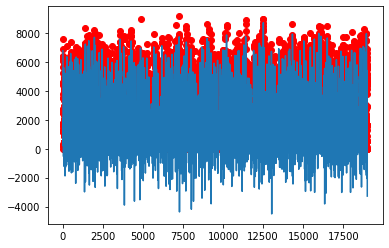

In [35]:
plt.scatter(x=np.arange(0,df4.ravel().shape[0]),y=df4.ravel(), color='r')
plt.plot(np.array(u).ravel())

Number of orders for each customer

In [36]:
pol = np.vstack(u).ravel()
npurch = df2.groupby('Customer ID')['Order'].max()
df5 = df3.dropna()
df5['pol'] = pol
npurchase = pd.DataFrame()
npurchase[['Customer ID','Max Order']] = npurch.reset_index()

In [37]:
a = []
for i in range(customers):
  a.append(pd.Series(filled3d[i].ravel()).rolling(window=3).mean().values)
df7 = pd.concat([filled,pd.Series(np.vstack(a).ravel())],1)
df7.columns = ['unique_month',	'Customer ID',	'Purchase Value',	'value']

Weights for weighted mean and std

In [39]:
def f(x,i):
    summ = 1e-5
    for n in range(x-1):
        summ+=(n+1)**2
    return (i-1)**2/summ

In [40]:
df6 = pd.merge(df2,npurchase,on='Customer ID', how='right')
df6['w'] = 1
for i in range(len(df6)):
    aq = df6['Max Order'][i]
    bq = df6['Order'][i]
    df6.loc[i,'w'] = f(aq,bq)
    #print(aq,bq,f(aq,bq))
df6['diff'] = df6['unique_month'].diff()
df6 = df6.iloc[1:,:]
df6['meantime'] = df6['w']*df6['diff']
df6 = df6.reset_index(drop=True)
df6['diff'] = np.clip(df6['diff'],0,np.inf)

In [41]:
meandict = dict(df6.dropna().groupby('Customer ID')['meantime'].sum())
npurchasedict = dict(npurchase.set_index('Customer ID'))

In [42]:
df6['ylc'] = 0
for i in range(len(df6)):
    if df6['Order'][i] == 1:
        df6.loc[i,'ylc'] = 0
    else:
        df6.loc[i,'ylc'] = (df6['diff'][i] - meandict[df6['Customer ID'][i]])**2

In [43]:
df6.head()

,Customer ID,Order,Purchase Time,Purchase Value,unique_month,month,Max Order,w,diff,meantime,ylc
0,1,2,2019-02-04 18:17:08.571428571,4205,2,2,17,0.000668,1.0,0.000668,0.026821
1,1,3,2019-03-11 12:34:17.142857143,6159,3,3,17,0.002674,1.0,0.002674,0.026821
2,1,4,2019-04-15 06:51:25.714285714,7829,4,4,17,0.006016,1.0,0.006016,0.026821
3,1,5,2019-05-20 01:08:34.285714286,8742,5,5,17,0.010695,1.0,0.010695,0.026821
4,1,6,2019-06-23 19:25:42.857142858,9140,6,6,17,0.016711,1.0,0.016711,0.026821


# Variables

In [44]:
v1 = npurchase['Max Order'].values
v2 = df6.dropna().groupby('Customer ID')['meantime'].sum()
v3 = df6.dropna().groupby('Customer ID')['ylc'].agg(lambda x:np.sqrt(x.sum())).fillna(0)
v4 = df2.groupby('Customer ID')['unique_month'].agg(lambda x: x.diff().max()).fillna(0)
v5 = df2.groupby('Customer ID')['unique_month'].agg(lambda x: 24 - x.diff().max()).fillna(0)
v6 = v2 + 2 * v3
v7 = v2 + 4 * v3
v8 = v2 + 8 * v3
v9 = []
for i in range(customers):
  if v5[i+1] <= v6[i+1]:
      v9.append('normal')
  elif v6[i+1] <= v5[i+1] and v5[i+1] <= v7[i+1]:
      v9.append('attricion')
  elif v7[i+1] <= v5[i+1] and v5[i+1] <= v8[i+1]:
      v9.append('at-risk')
  elif v8[i+1] <= v5[i+1]:
      v9.append('lost')
v9 = np.array(v9)
v10 = df5['value']
v11 = df5['pol']
v12 = df7['value'].dropna()
v13 = df5.groupby('Customer ID')['value'].max()
v14 = df5.groupby('Customer ID')['pol'].max()
v15 = df2.groupby('Customer ID')['Purchase Value'].mean().values
v16 = df3.groupby('Customer ID')['Purchase Value'].mean().values
v17 = df5.groupby('Customer ID')['pol'].mean().values
v18 = df2.groupby('Customer ID')['Purchase Value'].median().values
v19 = df3.groupby('Customer ID')['Purchase Value'].median().values
v20 = df5.groupby('Customer ID')['pol'].median().values
v21 = []
for i in range(len(df2)-5):
  di = np.minimum(5,npurchasedict['Max Order'][df2['Customer ID'][i]]-1)
  if npurchasedict['Max Order'][df2['Customer ID'][i]]-1 <= 1:
    v21.append(0)
  else:
    v21.append((df2['Purchase Value'][i+5] - df2['Purchase Value'][i+5-di])/df2['Purchase Value'][i+5-di])
v21 = np.array(v21)
v22 = []
mu = 0.3
for i in range(len(v21)):
  if v21[i] < mu:
      v22.append('steady')
  elif np.abs(v21[i]) <= mu:
      v22.append('within-limits')
  elif v21[i] > mu:
      v22.append('alternating')
v22 = np.array(v22)
v23 = []
a1,a2,a3 = 0.15 , 0.225, 0.3
for i in range(len(pol)-6):
  dkt = (pol[i+6] - pol[i]) / pol[i]
  if dkt <= -a3:
    v23.append('decreasing__')
  elif dkt > -a3 and dkt <= -a2:
    v23.append('decreasing_')
  elif dkt > -a2 and dkt <= -a1:
    v23.append('decreasing')
  elif dkt > -a1 and dkt <= a1:
    v23.append('stable')
  elif dkt > a1 and dkt <= a2:
    v23.append('increasing')
  elif dkt > a2 and dkt <= a3:
    v23.append('increasing+')
  elif dkt > a3:
    v23.append('increasing+')
v23 = np.array(v23)
v24 = np.random.randint(1,50,1000)

In [45]:
features = []
for i in [0,1,2,3,4,5,6,7,8,12,13,14,15,16,17,18,19,23]:
  print("v" + str(i+1))
  features.append(eval("v" + str(i+1)))

v1
v2
v3
v4
v5
v6
v7
v8
v9
v13
v14
v15
v16
v17
v18
v19
v20
v24


In [46]:
bin_df = pd.DataFrame(np.array(features).T, columns=['v'+str(x+1) for x in [0,1,2,3,4,5,6,7,8,12,13,14,15,16,17,18,19,23]])
bin_df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v13,v14,v15,v16,v17,v18,v19,v20,v24
0,17,1.1637700456967244,1.3319346316892648,2.0,22.0,3.827639309075254,6.4915085724537835,11.819247099210843,lost,7577.333333333333,6764.364432798098,6389.235294117647,4525.708333333333,4863.436393036961,6347.0,4842.5,5391.094812440412,25
1,5,3.999998666667111,2.66666577797281e-06,4.0,20.0,4.0000039999986665,4.0000093333302225,4.000019999993334,lost,2766.1666666666665,2116.355768427804,5302.4,1104.6666666666667,1245.725815425314,7045.0,0.0,1409.612012593533,26
2,17,1.1637700456967244,1.3319346316892648,2.0,22.0,3.827639309075254,6.4915085724537835,11.819247099210843,lost,6214.333333333333,5602.72099562033,5064.941176470588,3587.6666666666665,3915.9226582241813,3288.0,2987.5,4161.964688608132,40
3,11,1.8701298215550697,1.284204780676921,2.0,22.0,4.438539382908912,7.006948944262754,12.143768066970438,lost,5680.333333333333,4597.02977672397,6279.545454545455,2878.125,2557.2798970393183,6591.0,0.0,2624.7483071906245,27
4,4,4.92856790816578,0.9340468122974338,5.0,19.0,6.796661532760647,8.664755157355515,12.400942406545251,lost,2974.3333333333335,2189.635720164122,5758.0,959.6666666666666,709.0159315617102,5469.5,0.0,450.835899863529,23


In [47]:
num_bin_df = bin_df.drop(['v9'],1)
num_bin_df = num_bin_df.astype(float)

In [48]:
from itertools import combinations_with_replacement
def f1(df):
    new_df = pd.DataFrame()
    for p in combinations_with_replacement(df.columns,2):
            title = p
            new_df[title] = df[p[0]]*df[p[1]]
    return new_df

In [49]:
new_final_df = f1(num_bin_df)

In [50]:
cubes = num_bin_df**3
cubes.columns = 'cubed'+cubes.columns

In [51]:
cubes.head()

,cubedv1,cubedv2,cubedv3,cubedv4,cubedv5,cubedv6,cubedv7,cubedv8,cubedv13,cubedv14,cubedv15,cubedv16,cubedv17,cubedv18,cubedv19,cubedv20,cubedv24
0,4913.0,1.576164,2.362918e+00,8.0,10648.0,56.078065,273.550117,1651.085019,4.350600e+11,3.095145e+11,2.608235e+11,9.269572e+10,1.150349e+11,2.556851e+11,1.135557e+11,1.566863e+11,15625.0
1,125.0,63.999936,1.896294e-17,64.0,8000.0,64.000192,64.000448,64.000960,2.116582e+10,9.479077e+09,1.490793e+11,1.348012e+09,1.933158e+09,3.496576e+11,0.000000e+00,2.800908e+09,17576.0
2,4913.0,1.576164,2.362918e+00,8.0,10648.0,56.078065,273.550117,1651.085019,2.399847e+11,1.758721e+11,1.299341e+11,4.617812e+10,6.004852e+10,3.554638e+10,2.666390e+10,7.209334e+10,64000.0
3,1331.0,6.540565,2.117887e+00,8.0,10648.0,87.442030,344.022509,1790.854870,1.832827e+11,9.714757e+10,2.476194e+11,2.384125e+10,1.672379e+10,2.863215e+11,0.000000e+00,1.808269e+10,19683.0
4,64.0,119.718767,8.149030e-01,125.0,6859.0,313.969115,650.532331,1907.058746,2.631291e+10,1.049822e+10,1.909040e+11,8.838147e+08,3.564249e+08,1.636224e+11,0.000000e+00,9.163375e+07,12167.0


In [52]:
new_final_df.head()

,"(v1, v1)","(v1, v2)","(v1, v3)","(v1, v4)","(v1, v5)","(v1, v6)","(v1, v7)","(v1, v8)","(v1, v13)","(v1, v14)","(v1, v15)","(v1, v16)","(v1, v17)","(v1, v18)","(v1, v19)","(v1, v20)","(v1, v24)","(v2, v2)","(v2, v3)","(v2, v4)","(v2, v5)","(v2, v6)","(v2, v7)","(v2, v8)","(v2, v13)","(v2, v14)","(v2, v15)","(v2, v16)","(v2, v17)","(v2, v18)","(v2, v19)","(v2, v20)","(v2, v24)","(v3, v3)","(v3, v4)","(v3, v5)","(v3, v6)","(v3, v7)","(v3, v8)","(v3, v13)",...,"(v13, v18)","(v13, v19)","(v13, v20)","(v13, v24)","(v14, v14)","(v14, v15)","(v14, v16)","(v14, v17)","(v14, v18)","(v14, v19)","(v14, v20)","(v14, v24)","(v15, v15)","(v15, v16)","(v15, v17)","(v15, v18)","(v15, v19)","(v15, v20)","(v15, v24)","(v16, v16)","(v16, v17)","(v16, v18)","(v16, v19)","(v16, v20)","(v16, v24)","(v17, v17)","(v17, v18)","(v17, v19)","(v17, v20)","(v17, v24)","(v18, v18)","(v18, v19)","(v18, v20)","(v18, v24)","(v19, v19)","(v19, v20)","(v19, v24)","(v20, v20)","(v20, v24)","(v24, v24)"
0,289.0,19.784091,22.642889,34.0,374.0,65.069868,110.355646,200.927201,128814.666667,114994.195358,108617.0,76937.041667,82678.418682,107899.0,82322.5,91648.611811,425.0,1.354361,1.550066,2.327540,25.602941,4.454492,7.554623,13.754886,8818.273560,7872.164705,7435.600650,5266.883794,5659.921593,7386.448480,5635.556446,6273.994656,29.094251,1.774050e+00,2.663869,29.302562,5.098165,8.646265,15.742465,10092.512683,...,4.809333e+07,3.669324e+07,4.085012e+07,189433.333333,4.575663e+07,4.321912e+07,3.061354e+07,3.289806e+07,4.293342e+07,3.275643e+07,3.646733e+07,169109.110820,4.082233e+07,2.891582e+07,3.107364e+07,4.055248e+07,3.093987e+07,3.444497e+07,159730.882353,2.048204e+07,2.201049e+07,2.872467e+07,2.191574e+07,2.439852e+07,113142.708333,2.365301e+07,3.086823e+07,2.355119e+07,2.621925e+07,121585.909826,40284409.00,30735347.5,3.421728e+07,158675.0,23449806.25,2.610638e+07,121062.5,2.906390e+07,134777.370311,625.0
1,25.0,19.999993,0.000013,20.0,100.0,20.000020,20.000047,20.000100,13830.833333,10581.778842,26512.0,5523.333333,6228.629077,35225.0,0.0,7048.060063,130.0,15.999989,0.000011,15.999995,79.999973,16.000011,16.000032,16.000075,11064.662978,8465.420252,21209.592930,4418.665194,4982.901601,28179.990607,0.000000,5638.446171,103.999965,7.111106e-12,0.000011,0.000053,0.000011,0.000011,0.000011,0.007376,...,1.948764e+07,0.000000e+00,3.899222e+06,71920.333333,4.478962e+06,1.122176e+07,2.337868e+06,2.636399e+06,1.490973e+07,0.000000e+00,2.983241e+06,55025.249979,2.811545e+07,5.857385e+06,6.605337e+06,3.735541e+07,0.000000e+00,7.474327e+06,137862.400000,1.220288e+06,1.376112e+06,7.782377e+06,0.000000e+00,1.557151e+06,28721.333333,1.551833e+06,8.776138e+06,0.000000e+00,1.755990e+06,32388.871201,49632025.00,0.0,9.930717e+06,183170.0,0.00,0.000000e+00,0.0,1.987006e+06,36649.912327,676.0
2,289.0,19.784091,22.642889,34.0,374.0,65.069868,110.355646,200.927201,105643.666667,95246.256926,86104.0,60990.333333,66570.685190,55896.0,50787.5,70753.399706,680.0,1.354361,1.550066,2.327540,25.602941,4.454492,7.554623,13.754886,7232.054987,6520.278869,5894.426824,4175.219001,4557.233491,3826.475910,3476.763012,4843.569836,46.550802,1.774050e+00,2.663869,29.302562,5.098165,8.646265,15.742465,8277.085780,...,2.043273e+07,1.856532e+07,2.586384e+07,248573.333333,3.139048e+07,2.837745e+07,2.010070e+07,2.193982e+07,1.842175e+07,1.673813e+07,2.331833e+07,224108.839825,2.565363e+07,1.817132e+07,1.983392e+07,1.665353e+07,1.513151e+07,2.108011e+07,202597.647059,1.287135e+07,1.404903e+07,1.179625e+07,1.071815e+07,1.493174e+07,143506.666667,1.533445e+07,1.287555e+07,1.169882e+07,1.629793e+07,156636.906329,10810944.00,9822900.0,1.368454e+07,131520.0,8925156.25,1.243387e+07,119500.0,1.732195e+07,166478.587544,1600.0
3,121.0,20.571428,14.126253,22.0,242.0,48.823933,77.076438,133.581449,62483.666667,50567.327544,69075.0,31659.375000,28130.078867,72501.0,0.0,28872.231379,297.0,3.497386,2.401630,3.740260,41.142856,8.300645,13.103904,22.710423,10622.960763,8597.042476,11743.565220,5382.467393,4782.4453

In [53]:
logs = np.log1p(num_bin_df)
logs.columns = 'log'+logs.columns
logs.head()

,logv1,logv2,logv3,logv4,logv5,logv6,logv7,logv8,logv13,logv14,logv15,logv16,logv17,logv18,logv19,logv20,logv24
0,2.890372,0.771852,0.846698,1.098612,3.135494,1.574358,2.013770,2.550948,8.933049,8.819571,8.762526,8.417750,8.489706,8.755895,8.485393,8.592689,3.258097
1,1.791759,1.609438,0.000003,1.609438,3.044522,1.609439,1.609440,1.609442,7.925579,7.657923,8.576103,7.008204,7.128276,8.860215,0.000000,7.251779,3.295837
2,2.890372,0.771852,0.846698,1.098612,3.135494,1.574358,2.013770,2.550948,8.734775,8.631186,8.530295,8.185536,8.273062,8.098339,8.002527,8.333983,3.713572
3,2.484907,1.054357,0.826018,1.098612,3.135494,1.693511,2.080310,2.575948,8.644941,8.433383,8.745212,7.965242,7.847090,8.793612,0.000000,7.873121,3.332205
4,1.609438,1.779783,0.659615,1.791759,2.995732,2.053696,2.268486,2.595325,7.998111,7.691947,8.658519,6.867627,6.565287,8.607125,0.000000,6.113319,3.178054


# Prepare X,y

In [54]:
X = pd.concat([new_final_df,cubes,logs],1)

In [60]:
targetdf = pd.DataFrame(df2copy[df2copy['unique_month']==B]['Customer ID'].map(customerdict).reset_index().values, columns=['Customer ID','Target'])
merged = pd.merge(df2['Customer ID'].reset_index(drop=True).drop_duplicates(),targetdf.reset_index(drop=True), on='Customer ID',how='left').fillna(0)
#targett = np.hstack((np.ones(16),np.zeros(1000-16)))#np.random.randint(0,2,1000)

In [61]:
target = merged['Target']

In [62]:
pd.Series(target).value_counts()

0.0    950
1.0     50
Name: Target, dtype: int64

In [57]:
target = merged['Target'].values

In [63]:
X.shape, target.shape

((1000, 187), (1000,))

# Split & Fit

In [64]:
pd.Series(target).value_counts()

0.0    950
1.0     50
Name: Target, dtype: int64

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=0)

In [66]:
from sklearn.linear_model import LogisticRegression
loglasso = LogisticRegression(penalty='l1', solver='liblinear')
loglasso.fit(X_train,y_train)
pred = loglasso.predict(X_test)

In [67]:
from sklearn.metrics import accuracy_score
>>> accuracy_score(y_test, pred)

0.905

In [68]:
from sklearn.metrics import classification_report
>>> print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       187
         1.0       0.20      0.15      0.17        13

    accuracy                           0.91       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.89      0.91      0.90       200



In [69]:
from sklearn.metrics import confusion_matrix
>>> print(confusion_matrix(y_test, pred))

[[179   8]
 [ 11   2]]


In [70]:
!pip install scikit-elm

In [71]:
!pip install dask[dataframe] --upgrade
from skelm import ELMClassifier

     |████████████████████████████████| 118 kB 5.1 MB/s 


In [72]:
clf = ELMClassifier()
clf.fit(X_train, y_train)
pred2 = clf.predict(X_test)

In [73]:
accuracy_score(y_test, pred2)

0.925

In [74]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       187
         1.0       0.00      0.00      0.00        13

    accuracy                           0.93       200
   macro avg       0.47      0.49      0.48       200
weighted avg       0.87      0.93      0.90       200



In [75]:
print(confusion_matrix(y_test, pred2))

[[185   2]
 [ 13   0]]


In [76]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train, y_train)
pred3 = xg.predict(X_test)

In [77]:
accuracy_score(y_test, pred3)

0.935

In [78]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       187
         1.0       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200



In [79]:
print(confusion_matrix(y_test, pred3))

[[187   0]
 [ 13   0]]


# Kfold accuracy

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)
models = [loglasso,clf,xg]
scores = []
for model in models:
  scores.append(cross_val_score(model, X, target, scoring='accuracy', cv=cv))

In [ ]:
scores

[array([0.945, 0.94 , 0.94 , 0.925, 0.925]),
 array([0.965, 0.955, 0.97 , 0.96 , 0.955]),
 array([0.965, 0.955, 0.97 , 0.96 , 0.955])]

In [ ]:
%%shell
jupyter nbconvert --to html /content/mdpgrupfinal.ipynb

[NbConvertApp] Converting notebook /content/mdpgrupfinal.ipynb to html
[NbConvertApp] Writing 388546 bytes to /content/mdpgrupfinal.html
